# old

## Functions (old)

In [27]:
from scipy.stats import genextreme

In [25]:
def analyze_gev(
    metric_id,
    ensemble,
    ssp,
    city,
    time_slice,
    groupby_columns,
    info_to_add=None,
    drop_data=None,
):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(
        f"{project_data_path}/timeseries/original_grid/{metric_id}_{ensemble}_{ssp}_{city}.csv"
    )

    # Filter the data by the provided time slice
    df = df[df["time"].isin(np.arange(*time_slice))]

    # Drop data if selected
    if drop_data is not None:
        for key, value in drop_data.items():
            df = df[df[key] != value]

    # Initialize an empty list to store results
    results = []

    # Find unique combinations of the specified groupby columns
    unique_combinations = df[groupby_columns].drop_duplicates()

    # Loop through each unique combination of values in the specified columns
    for _, combination in unique_combinations.iterrows():
        # Subset the data based on this combination
        subset = df
        for col in groupby_columns:
            subset = subset[subset[col] == combination[col]]

        # Extract the data for the specified metric
        data = subset[metric_id.split("_")[1]].dropna().to_numpy()
        data = -1 * data if metric_id == "min_tasmin" else data

        # Fit a GEV distribution to the data if not empty
        if len(data) > 0:
            # shape, loc, scale = genextreme.fit(data, method='MLE')
            lmom = gevu.samlmom3(data)
            loc, scale, shape = gevu.pargev(lmom)

            # Calculate the 100-year return level
            return_period = 100
            return_level_100 = genextreme.ppf(
                1 - 1 / return_period, shape, loc=loc, scale=scale
            )
            return_level_100 = (
                -1 * return_level_100
                if metric_id == "min_tasmin"
                else return_level_100
            )

            # Prepare the result dictionary with the grouping columns and GEV results
            result = {col: combination[col] for col in groupby_columns}
            result.update(
                {
                    "shape": shape,
                    "location": loc,
                    "scale": scale,
                    "rl100": return_level_100,
                    "ensemble": ensemble,
                    "ssp": ssp,
                }
            )
            if info_to_add is not None:
                result.update(info_to_add)

            # Append the result to the results list
            results.append(result)

    # Convert the results list into a DataFrame
    results_df = pd.DataFrame(results)

    return results_df

In [26]:
def variance_decomposition(df, var_id):
    # IV variance component
    min_filter = df.groupby(["ensemble", "gcm", "ssp"]).count() >= 5
    U_iv = (
        df.groupby(["ensemble", "gcm", "ssp"])
        .var(numeric_only=True)
        .where(min_filter)
        .dropna()[var_id]
        .mean()
    )

    # GCM variance component
    min_filter_response = df.groupby(["ensemble", "gcm", "ssp"]).count() >= 5
    U_response = (
        df.groupby(["ensemble", "gcm", "ssp"])
        .mean(numeric_only=True)
        .where(min_filter_response)
        .dropna()
        .groupby(["ensemble", "ssp"])[var_id]
        .var(ddof=0)
        .mean()
    )

    # DSBC variance component
    min_filter_dsbc = df.groupby(["gcm", "ssp", "member"]).count() >= 2
    U_dsbc = (
        df.groupby(["gcm", "ssp", "member"])
        .var(numeric_only=True)
        .where(min_filter_dsbc)
        .dropna()[var_id]
        .mean()
    )

    # SSP variance component
    U_ssp = (
        df.groupby(["ensemble", "ssp"])
        .mean(numeric_only=True)
        .groupby("ensemble")[var_id]
        .var()
        .dropna()
        .mean()
    )

    # Collect results in a dictionary
    results = {
        "Scenario": U_ssp,
        "Variability": U_iv,
        "Response": U_response,
        "Downscaling": U_dsbc,
    }

    return pd.DataFrame.from_dict(results, orient="index", columns=["u"])

In [27]:
def custom_var(x):
    # return np.mean(np.abs(x - np.mean(x)))
    return np.max(x) - np.min(x)
    # return np.quantile(x, 0.95) - np.quantile(x, 0.05)


def custom_decomposition(df, var_id):
    # IV component
    min_filter = df.groupby(["ensemble", "gcm", "ssp"])[var_id].count() >= 5
    U_iv = (
        df.groupby(["ensemble", "gcm", "ssp"])[var_id]
        .apply(custom_var)
        .where(min_filter)
        .dropna()
        .mean()
    )

    # GCM component
    min_filter_response = (
        df.groupby(["ensemble", "gcm", "ssp"])[var_id].count() >= 5
    )
    U_response = (
        df.groupby(["ensemble", "gcm", "ssp"])[var_id]
        .mean(numeric_only=True)
        .where(min_filter_response)
        .dropna()
        .groupby(["ensemble", "ssp"])
        .apply(custom_var)
        .mean()
    )

    # DSBC component
    min_filter_dsbc = df.groupby(["gcm", "ssp", "member"])[var_id].count() >= 2
    U_dsbc = (
        df.groupby(["gcm", "ssp", "member"])[var_id]
        .apply(custom_var)
        .where(min_filter_dsbc)
        .dropna()
        .mean()
    )

    # SSP component
    U_ssp = (
        df.groupby(["ensemble", "ssp"])[var_id]
        .mean(numeric_only=True)
        .groupby("ensemble")
        .apply(custom_var)
        .dropna()
        .mean()
    )

    # Collect results in a dictionary
    results = {
        "Scenario": U_ssp,
        "Variability": U_iv,
        "Response": U_response,
        "Downscaling": U_dsbc,
    }

    return pd.DataFrame.from_dict(results, orient="index", columns=["u"])

In [28]:
# Plotting functions
def plot_boxplot(df, plot_col, limits, positions, color, ax):
    # Filter data below limit
    data = df[(df[plot_col] < limits[1]) & (df[plot_col] > limits[0])][
        plot_col
    ].to_numpy()

    # Plot
    bp = ax.boxplot(
        x=data,
        positions=positions,
        patch_artist=True,
        capprops=dict(color=color, linewidth=2),
        boxprops=dict(color=color, linewidth=2),
        whiskerprops=dict(color=color, linewidth=2),
        flierprops=dict(
            markerfacecolor=color, linestyle="none", markeredgecolor=color
        ),
        medianprops=dict(color="white", linewidth=2, zorder=5),
        vert=False,
        showmeans=False,
        widths=0.4,
    )
    # whis=(0.5, 99.5), showfliers=False,

    for patch in bp["boxes"]:
        patch.set_facecolor(color)

In [29]:
def plot_ds_differences(df, plot_col, ax=None):
    ssp_colors = {
        "ssp245": "#1b9e77",
        "ssp370": "#7570b3",
        "ssp585": "#d95f02",
    }

    # Create a new figure and axis if none are provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    # Group by fixed columns
    group_cols = ["gcm", "member", "ssp"]
    diff_cols = ["ensemble"]
    grouped = df.groupby(group_cols)

    # Track the y position for each unique combination of fixed columns
    y_labels = []
    y_pos = 0

    # Loop over each group of fixed columns
    for fixed_values, group in grouped:
        # Ensure there are at least two unique combinations of diff_cols
        if group[diff_cols].drop_duplicates().shape[0] < 2:
            continue  # Skip if there aren't at least two unique combinations

        # Sort by diff_cols to ensure consistent line plots
        group_sorted = group.sort_values(by=diff_cols)

        # Generate a label for the y-axis with only values, separated by spaces
        gcm, member, ssp = fixed_values
        y_labels.append(f"{gcm} {member}")

        # Plot values with a line connecting points that differ by diff_cols
        ax.plot(
            group_sorted[plot_col],
            [y_pos] * len(group_sorted),  # Fixed y-position for this group
            marker="o",
            linestyle="-",
            color=ssp_colors[ssp],
        )

        # Increment y position for the next label
        y_pos += 1

    # Customize plot
    ax.set_yticks(range(len(y_labels)))
    ax.set_yticklabels(y_labels, fontsize=10)
    ax.set_xlabel(plot_col)
    ax.grid(alpha=0.2)

In [30]:
def fit_gev_all(
    metric_id, city, time_slice_proj=[2050, 2100], time_slice_hist=[1950, 2014]
):
    # Drop data for temperature
    if "tas" in metric_id.split("_")[1]:
        drop_data = {"gcm": "TaiESM1"}
    else:
        drop_data = None

    ###############
    # Projections
    ###############
    # STAR
    star_ssp245_proj = analyze_gev(
        metric_id,
        "STAR-ESDM",
        "ssp245",
        city,
        time_slice_proj,
        ["gcm"],
        info_to_add={"member": "r1i1p1f1"},
        drop_data=drop_data,
    )
    star_ssp585_proj = analyze_gev(
        metric_id,
        "STAR-ESDM",
        "ssp585",
        city,
        time_slice_proj,
        ["gcm"],
        info_to_add={"member": "r1i1p1f1"},
        drop_data=drop_data,
    )

    # LOCA
    loca_ssp245_proj = analyze_gev(
        metric_id,
        "LOCA2",
        "ssp245",
        city,
        time_slice_proj,
        ["gcm", "member"],
        drop_data=drop_data,
    )
    loca_ssp370_proj = analyze_gev(
        metric_id,
        "LOCA2",
        "ssp370",
        city,
        time_slice_proj,
        ["gcm", "member"],
        drop_data=drop_data,
    )
    loca_ssp585_proj = analyze_gev(
        metric_id,
        "LOCA2",
        "ssp585",
        city,
        time_slice_proj,
        ["gcm", "member"],
        drop_data=drop_data,
    )

    # GARD-LENS
    gard_proj = analyze_gev(
        metric_id,
        "GARD-LENS",
        "ssp370",
        city,
        time_slice_proj,
        ["gcm", "member"],
        drop_data=drop_data,
    )

    ###############
    # Historical
    ###############
    # STAR
    star_ssp245_hist = analyze_gev(
        metric_id,
        "STAR-ESDM",
        "ssp245",
        city,
        time_slice_hist,
        ["gcm"],
        info_to_add={"member": "r1i1p1f1"},
    )
    star_ssp585_hist = analyze_gev(
        metric_id,
        "STAR-ESDM",
        "ssp585",
        city,
        time_slice_hist,
        ["gcm"],
        info_to_add={"member": "r1i1p1f1"},
    )

    # LOCA
    loca_hist = analyze_gev(
        metric_id,
        "LOCA2",
        "historical",
        city,
        time_slice_hist,
        ["gcm", "member"],
    )

    # GARD-LENS
    gard_hist = analyze_gev(
        metric_id,
        "GARD-LENS",
        "ssp370",
        city,
        time_slice_hist,
        ["gcm", "member"],
    )

    #####################
    # Get differences
    ####################
    def merge_and_diff(df_proj, df_hist):
        df = pd.merge(
            df_proj,
            df_hist,
            on=["gcm", "member", "ensemble", "ssp"],
            suffixes=("_proj", "_hist"),
        )
        df["rl100_diff"] = df["rl100_proj"] - df["rl100_hist"]
        return df

    # STAR
    star_ssp245 = merge_and_diff(star_ssp245_proj, star_ssp245_hist)
    star_ssp585 = merge_and_diff(star_ssp585_proj, star_ssp585_hist)

    # LOCA
    loca_ssp245 = merge_and_diff(
        loca_ssp245_proj, loca_hist.replace("historical", "ssp245")
    )
    loca_ssp370 = merge_and_diff(
        loca_ssp370_proj, loca_hist.replace("historical", "ssp370")
    )
    loca_ssp585 = merge_and_diff(
        loca_ssp585_proj, loca_hist.replace("historical", "ssp585")
    )

    # GARD
    gard = merge_and_diff(gard_proj, gard_hist)

    ##################
    # Combine all
    ##################
    df_all = pd.concat(
        [star_ssp245, star_ssp585, loca_ssp245, loca_ssp370, loca_ssp585, gard]
    )

    # Consistent GCM naming
    df_all = (
        df_all.replace("cesm2", "CESM2-LENS")
        .replace("ecearth3", "EC-Earth3")
        .replace("canesm5", "CanESM5")
    )

    return df_all

In [31]:
def plot_boxplots(
    df_all,
    limits,
    plot_col,
    xlabel,
    ax,
    time_slice_proj=[2050, 2100],
    time_slice_hist=[1950, 2014],
):
    ssp_colors = {
        "ssp245": "#1b9e77",
        "ssp370": "#7570b3",
        "ssp585": "#d95f02",
    }
    ssp_labels = {
        "ssp245": "SSP2-4.5",
        "ssp370": "SSP3-7.0",
        "ssp585": "SSP5-8.5",
    }

    # Subset
    star_ssp245 = df_all[
        (df_all["ensemble"] == "STAR-ESDM") & (df_all["ssp"] == "ssp245")
    ]
    star_ssp585 = df_all[
        (df_all["ensemble"] == "STAR-ESDM") & (df_all["ssp"] == "ssp585")
    ]

    loca_ssp245 = df_all[
        (df_all["ensemble"] == "LOCA2") & (df_all["ssp"] == "ssp245")
    ]
    loca_ssp370 = df_all[
        (df_all["ensemble"] == "LOCA2") & (df_all["ssp"] == "ssp370")
    ]
    loca_ssp585 = df_all[
        (df_all["ensemble"] == "LOCA2") & (df_all["ssp"] == "ssp585")
    ]

    gard_canesm5 = df_all[
        (df_all["ensemble"] == "GARD-LENS") & (df_all["gcm"] == "CanESM5")
    ]
    gard_ecearth3 = df_all[
        (df_all["ensemble"] == "GARD-LENS") & (df_all["gcm"] == "EC-Earth3")
    ]
    gard_cesm2 = df_all[
        (df_all["ensemble"] == "GARD-LENS") & (df_all["gcm"] == "CESM2-LENS")
    ]

    # STAR
    plot_boxplot(
        star_ssp245, plot_col, limits, [1], ssp_colors["ssp245"], ax=ax
    )
    plot_boxplot(
        star_ssp585, plot_col, limits, [1.5], ssp_colors["ssp585"], ax=ax
    )

    # LOCA
    plot_boxplot(
        loca_ssp245, plot_col, limits, [2.5], ssp_colors["ssp245"], ax=ax
    )
    plot_boxplot(
        loca_ssp370, plot_col, limits, [3], ssp_colors["ssp370"], ax=ax
    )
    plot_boxplot(
        loca_ssp585, plot_col, limits, [3.5], ssp_colors["ssp585"], ax=ax
    )

    # GARD-LENS
    plot_boxplot(
        gard_canesm5, plot_col, limits, [4.5], ssp_colors["ssp370"], ax=ax
    )
    plot_boxplot(
        gard_ecearth3, plot_col, limits, [5], ssp_colors["ssp370"], ax=ax
    )
    plot_boxplot(
        gard_cesm2, plot_col, limits, [5.5], ssp_colors["ssp370"], ax=ax
    )

    ax.set_yticks(
        [1.25, 3, 4.5, 5, 5.5],
        ["STAR-ESDM", "LOCA2", "CanESM5", "EC-Earth3", "CESM2"],
    )

    ax.grid(alpha=0.2)
    ax.set_xlabel(xlabel)
    if "proj" in plot_col:
        ax.set_title(
            f"{city.capitalize()} ({time_slice_proj[0]}-{time_slice_proj[1]})"
        )
    elif "diff" in plot_col:
        ax.set_title(
            f"{city.capitalize()}: Future ({time_slice_proj[0]}-{time_slice_proj[1]}) minus historical ({time_slice_hist[0]}-{time_slice_hist[1]})"
        )

    legend_elements = [
        Line2D([0], [0], color=ssp_colors[ssp], lw=4, label=ssp_labels[ssp])
        for ssp in ssp_colors.keys()
    ]
    ax.legend(handles=legend_elements)

In [32]:
def plot_decomps(
    df_all,
    limits,
    plot_col,
    xlabel,
    time_slice_proj=[2050, 2100],
    time_slice_hist=[1950, 2014],
):
    fig, axs = plt.subplots(1, 3, figsize=(14, 4), width_ratios=[2, 1, 1])

    ssp_colors = {
        "ssp245": "#1b9e77",
        "ssp370": "#7570b3",
        "ssp585": "#d95f02",
    }
    ssp_labels = {
        "ssp245": "SSP2-4.5",
        "ssp370": "SSP3-7.0",
        "ssp585": "SSP5-8.5",
    }

    ## Boxplots
    ax = axs[0]
    plot_boxplots(df_all, limits, plot_col, xlabel, ax)

    ## UQ: variance
    ax = axs[1]
    variance_decomposition(df_all, plot_col).plot.bar(
        ax=ax, color="grey", label=None, rot=-45
    )
    ax.get_legend().remove()
    ax.grid(alpha=0.2)
    ax.set_yticklabels("")
    ax.set_title("Variance Decomp.")

    ## UQ: range
    ax = axs[2]
    custom_decomposition(df_all, plot_col).plot.bar(
        ax=ax, color="grey", label=None, rot=-45
    )
    ax.get_legend().remove()
    ax.grid(alpha=0.2)
    ax.set_yticklabels("")
    ax.set_title("Range ~Decomp.~")

    plt.show()

In [36]:
def plot_decomp_qual(df_all, limits, plot_col, xlabel):
    # Understand the decomp
    ssp_colors = {
        "ssp245": "#1b9e77",
        "ssp370": "#7570b3",
        "ssp585": "#d95f02",
    }
    ssp_labels = {
        "ssp245": "SSP2-4.5",
        "ssp370": "SSP3-7.0",
        "ssp585": "SSP5-8.5",
    }

    fig, axs = plt.subplots(
        1, 3, figsize=(15, 6), layout="constrained", sharey=False
    )

    # Subset
    loca_ssp245 = df_all[
        (df_all["ensemble"] == "LOCA2") & (df_all["ssp"] == "ssp245")
    ]
    loca_ssp370 = df_all[
        (df_all["ensemble"] == "LOCA2") & (df_all["ssp"] == "ssp370")
    ]
    loca_ssp585 = df_all[
        (df_all["ensemble"] == "LOCA2") & (df_all["ssp"] == "ssp585")
    ]

    gard = df_all[(df_all["ensemble"] == "GARD-LENS")]

    # IV
    ax = axs[0]
    idx = 0
    ylabels = []
    # Loop through ensembles
    for ensemble in [loca_ssp245, loca_ssp585, gard]:
        ensemble_name = ensemble["ensemble"].iloc[0]
        # Filter minimum members = 5
        min_filter = ensemble.groupby("gcm")[plot_col].count() >= 5
        gcms = min_filter[min_filter].index
        # Loop through GCMs
        for gcm in gcms:
            ssp = ensemble["ssp"][0]
            data = ensemble[ensemble["gcm"] == gcm]
            if len(data) > 10:
                plot_boxplot(
                    data, plot_col, limits, [idx], ssp_colors[ssp], ax
                )
            else:
                ax.scatter(
                    y=[idx] * len(data),
                    x=data[plot_col],
                    c=ssp_colors[ssp],
                    s=50,
                )
            idx += 1
            ylabels.append(
                f"{ensemble_name}\n{gcm} ({len(ensemble[ensemble['gcm'] == gcm])})"
            )

    ax.grid(alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_title("Internal variability")
    ax.set_yticks(np.arange(len(ylabels)), ylabels, fontsize=10)

    legend_elements = [
        Line2D([0], [0], color=ssp_colors[ssp], lw=4, label=ssp_labels[ssp])
        for ssp in ssp_colors.keys()
    ]
    ax.legend(handles=legend_elements)

    ## Response
    ax = axs[1]
    idx = 0
    ylabels = []
    # Loop through ensembles
    for ensemble in [loca_ssp245, loca_ssp585, gard]:
        ensemble_name = ensemble["ensemble"].iloc[0]
        ssp = ensemble["ssp"][0]
        # Filter minimum members = 5
        min_filter = ensemble.groupby("gcm")[plot_col].count() >= 5
        gcms = min_filter[min_filter].index
        # Plot
        plot_df = pd.DataFrame(
            ensemble.groupby("gcm")[plot_col].mean().loc[gcms]
        )  # forced responses
        # plot_boxplot(plot_df, plot_col, limits, [idx], ssp_colors[ssp], ax)
        ax.scatter(
            y=[idx] * len(plot_df),
            x=plot_df[plot_col],
            c=ssp_colors[ssp],
            s=100,
        )
        idx += 1
        ylabels.append(f"{ensemble_name}\n{ssp} ({len(plot_df)})")

    ax.set_yticks(np.arange(len(ylabels)), ylabels, fontsize=10)
    ax.grid(alpha=0.2)
    ax.set_xlabel(xlabel)
    ax.set_title("Response uncertainty")

    ## Downscaling
    ax = axs[2]
    plot_ds_differences(df_all, plot_col, ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_title("Downscaling uncertainty")

    plt.show()

In [34]:
def plot_timeseries(city, metric, gcm, ssp):
    var_id = metric_id.split("_")[1]

    member = "r1i1p1f1"

    fig, ax = plt.subplots()

    df = pd.read_csv(
        f"{project_data_path}/timeseries/original_grid/{metric_id}_STAR-ESDM_{ssp}_{city}.csv"
    )
    df[(df["gcm"] == gcm)].plot(
        x="time", y=var_id, ax=ax, label="STAR", lw=2, color="C0"
    )

    df = pd.read_csv(
        f"{project_data_path}/timeseries/original_grid/{metric_id}_LOCA2_{ssp}_{city}.csv"
    )
    df[(df["gcm"] == gcm) & (df["member"] == member)].plot(
        x="time", y=var_id, ax=ax, label="LOCA2", lw=2, color="C1"
    )

    df = pd.read_csv(
        f"{project_data_path}/timeseries/original_grid/{metric_id}_LOCA2_historical_{city}.csv"
    )
    df[(df["gcm"] == gcm) & (df["member"] == member)].plot(
        x="time", y=var_id, ax=ax, label="", lw=2, color="C1"
    )

    ax.legend()
    ax.grid()
    plt.show()

## Analysis (old)

### Tasmax: projections

In [38]:
metric_id = "max_tasmax"
city = "nyc"

df_all = fit_gev_all(metric_id, city)

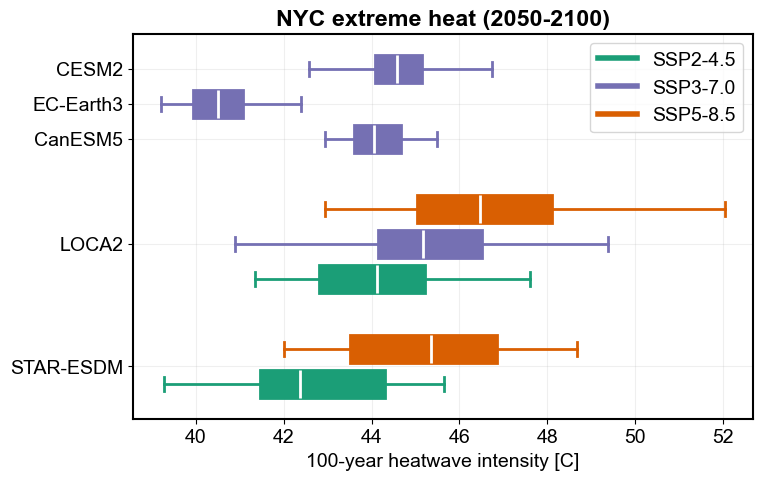

In [40]:
plot_col = "rl100_proj"
limits = [0, np.inf]
xlabel = "100-year heatwave intensity [C]"

fig, ax = plt.subplots(figsize=(8, 5))
plot_boxplots(df_all, limits, plot_col, xlabel, ax)
ax.set_title("NYC extreme heat (2050-2100)", fontweight="bold")
# plt.savefig("../figs/sf_100yr_boxplots.png", dpi=600, bbox_inches="tight")
plt.show()

In [41]:
denver = [40.712778, -74.006111]
uc_norm.sel(lat=denver[0], lon=360+denver[1], method='nearest')

<xarray.Dataset> Size: 48B
Dimensions:  ()
Coordinates:
    lat      float64 8B 40.72
    lon      float64 8B 286.0
Data variables:
    gcm_uc   float64 8B 0.3151
    ssp_uc   float64 8B 0.23
    iv_uc    float64 8B 0.2852
    dsc_uc   float64 8B 0.1697

<Axes: title={'center': '100yr_return_level'}, xlabel='ssp'>

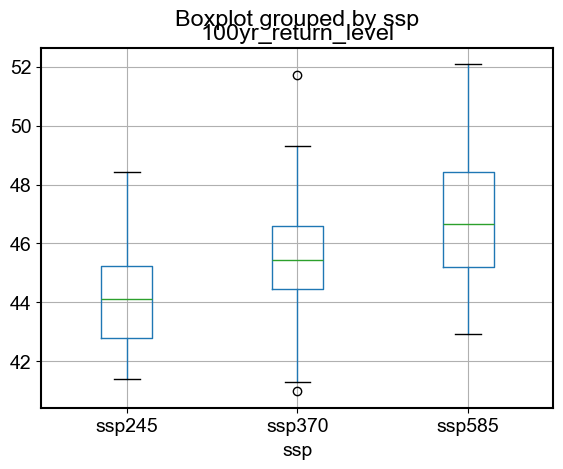

In [42]:
ds_loca.sel(lat=denver[0], lon=360+denver[1], method='nearest').to_dataframe().dropna().boxplot(column='100yr_return_level',by='ssp')

<Axes: title={'center': '100yr_return_level'}, xlabel='gcm'>

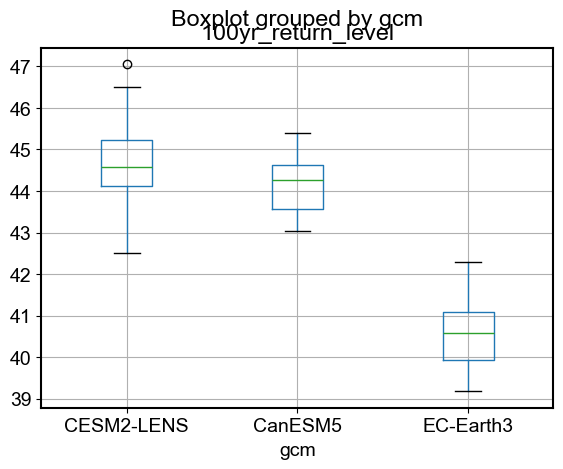

In [43]:
ds_gard.sel(lat=denver[0], lon=360+denver[1], method='nearest').to_dataframe().dropna().boxplot(column='100yr_return_level',by='gcm')

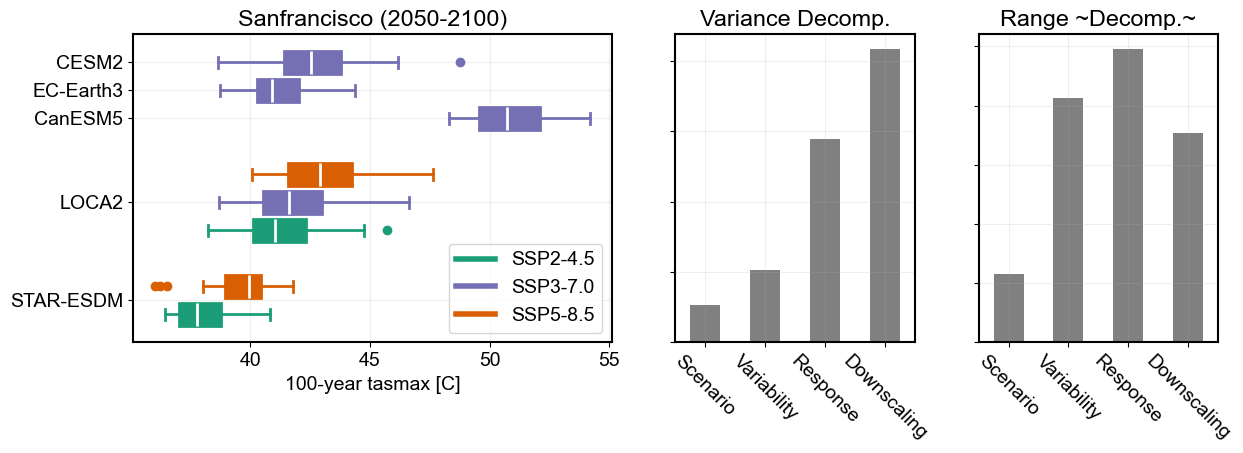

In [40]:
plot_col = "rl100_proj"
limits = [-np.inf, np.inf]
xlabel = "100-year tasmax [C]"

plot_decomps(df_all, limits, plot_col, xlabel)

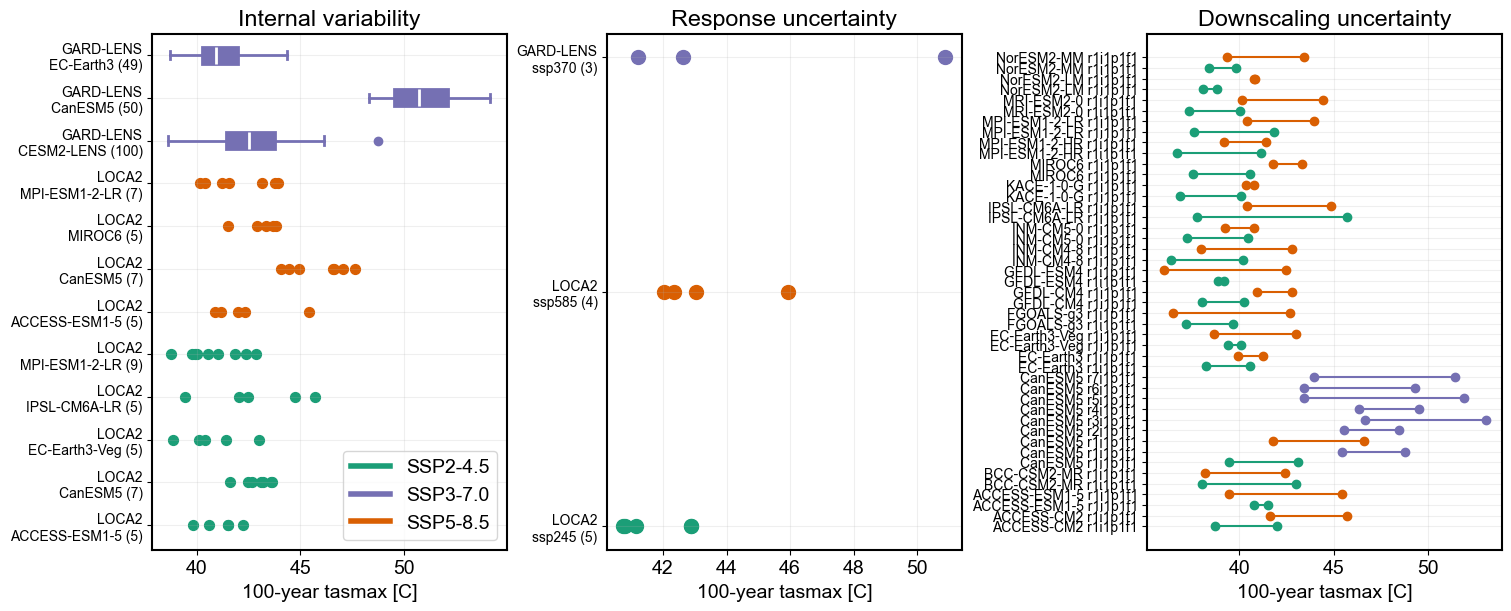

In [41]:
plot_decomp_qual(df_all, limits, plot_col, xlabel)

### Tasmax: change

In [18]:
metric_id = "max_tasmax"
city = "sanfrancisco"

df_all = fit_gev_all(metric_id, city)

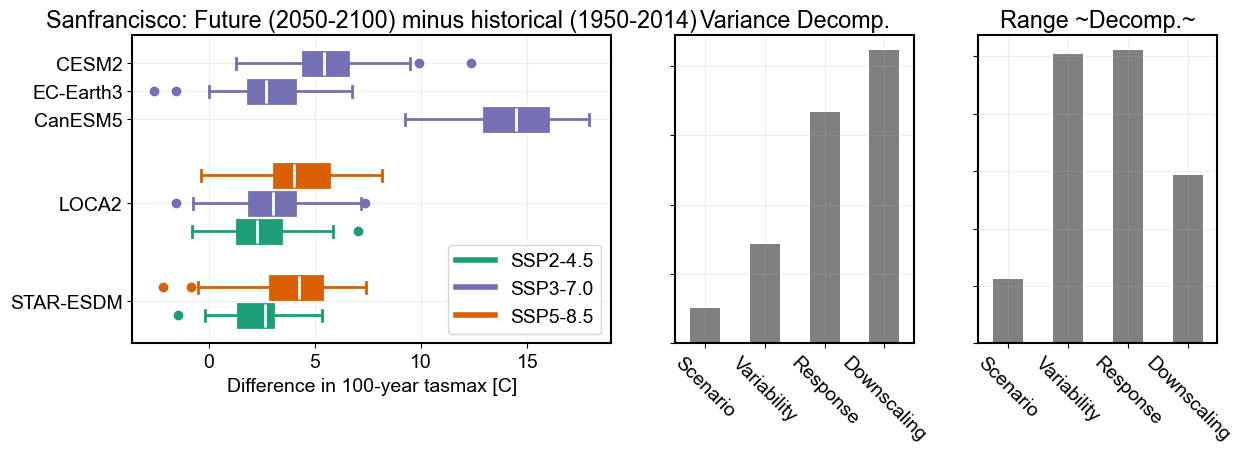

In [19]:
plot_col = "rl100_diff"
limits = [-np.inf, np.inf]
xlabel = "Difference in 100-year tasmax [C]"

plot_decomps(df_all, limits, plot_col, xlabel)

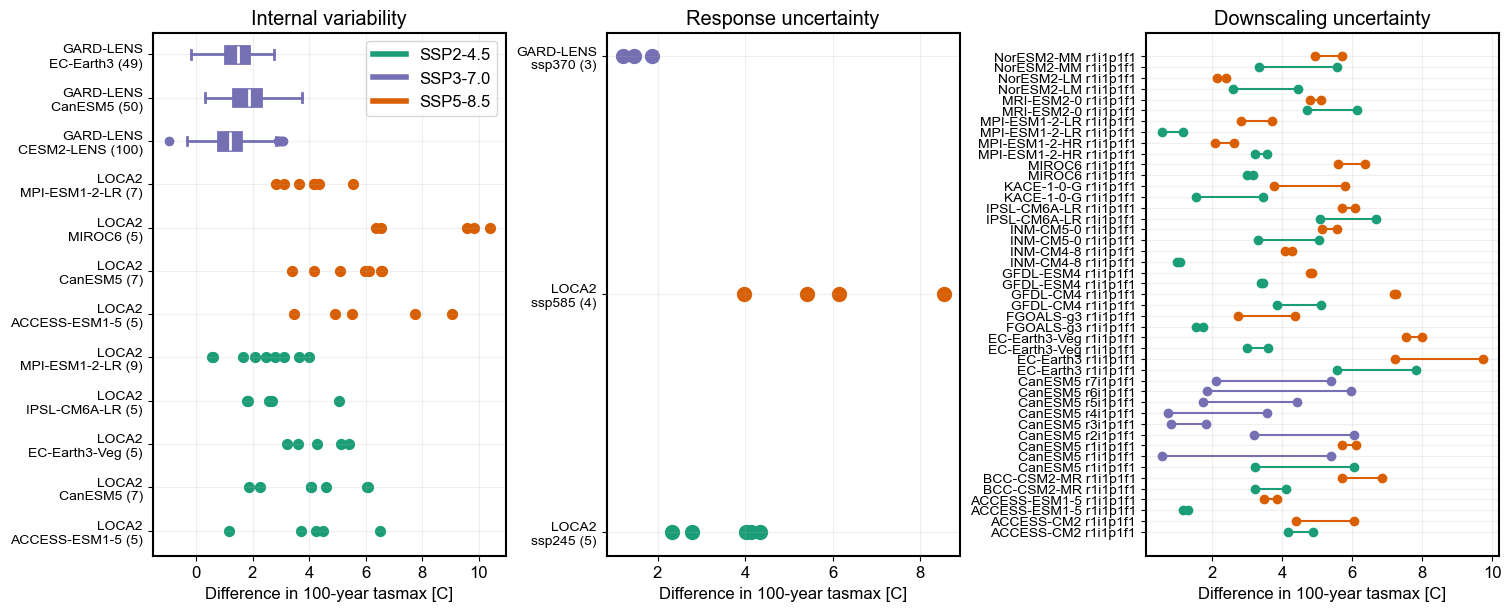

In [24]:
plot_decomp_qual(df_all, limits, plot_col, xlabel)

### Precip: proj

In [26]:
metric_id = "max_pr"
city = "denver"

df_all = fit_gev_all(metric_id, city)

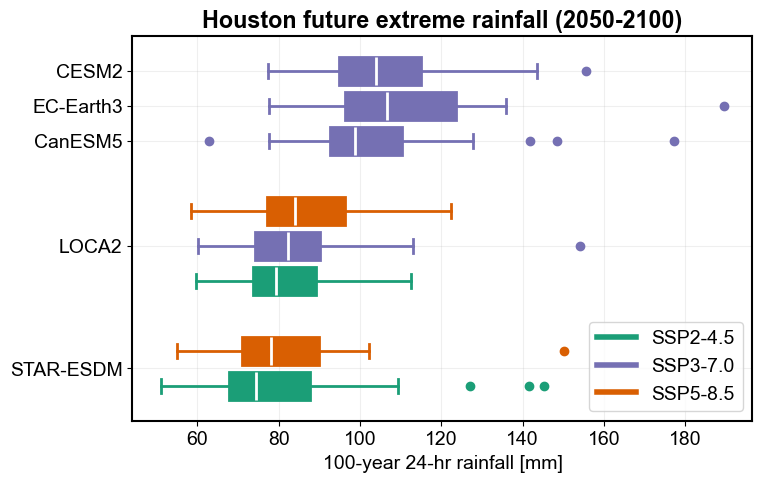

In [27]:
plot_col = "rl100_proj"
limits = [0, np.inf]
xlabel = "100-year 24-hr rainfall [mm]"

fig, ax = plt.subplots(figsize=(8, 5))
plot_boxplots(df_all, limits, plot_col, xlabel, ax)
ax.set_title("Houston future extreme rainfall (2050-2100)", fontweight="bold")
plt.savefig("../figs/houston_100yr_boxplots.png", dpi=600, bbox_inches="tight")

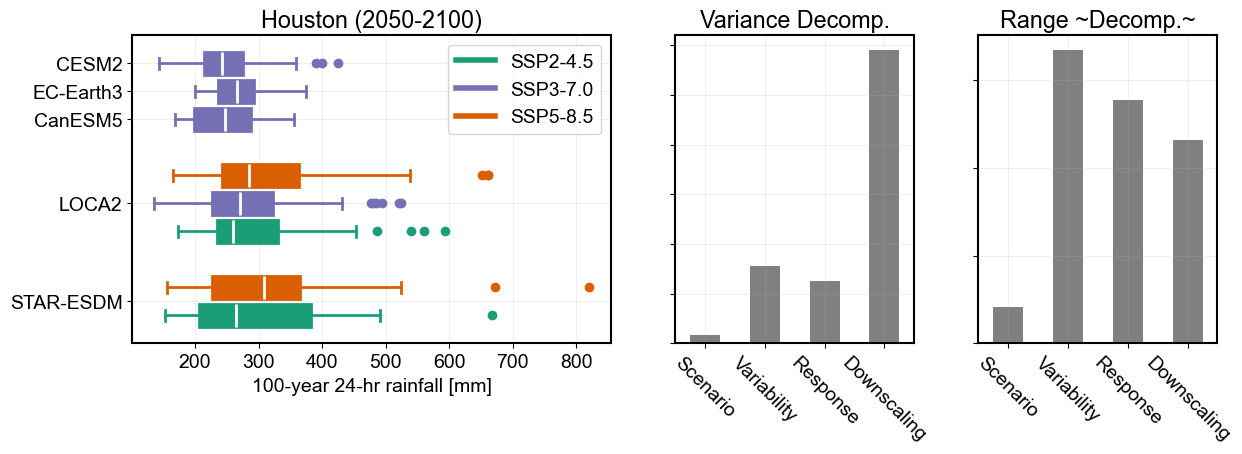

In [34]:
plot_col = "rl100_proj"
limits = [0, np.inf]
xlabel = "100-year 24-hr rainfall [mm]"

plot_decomps(df_all, limits, plot_col, xlabel)

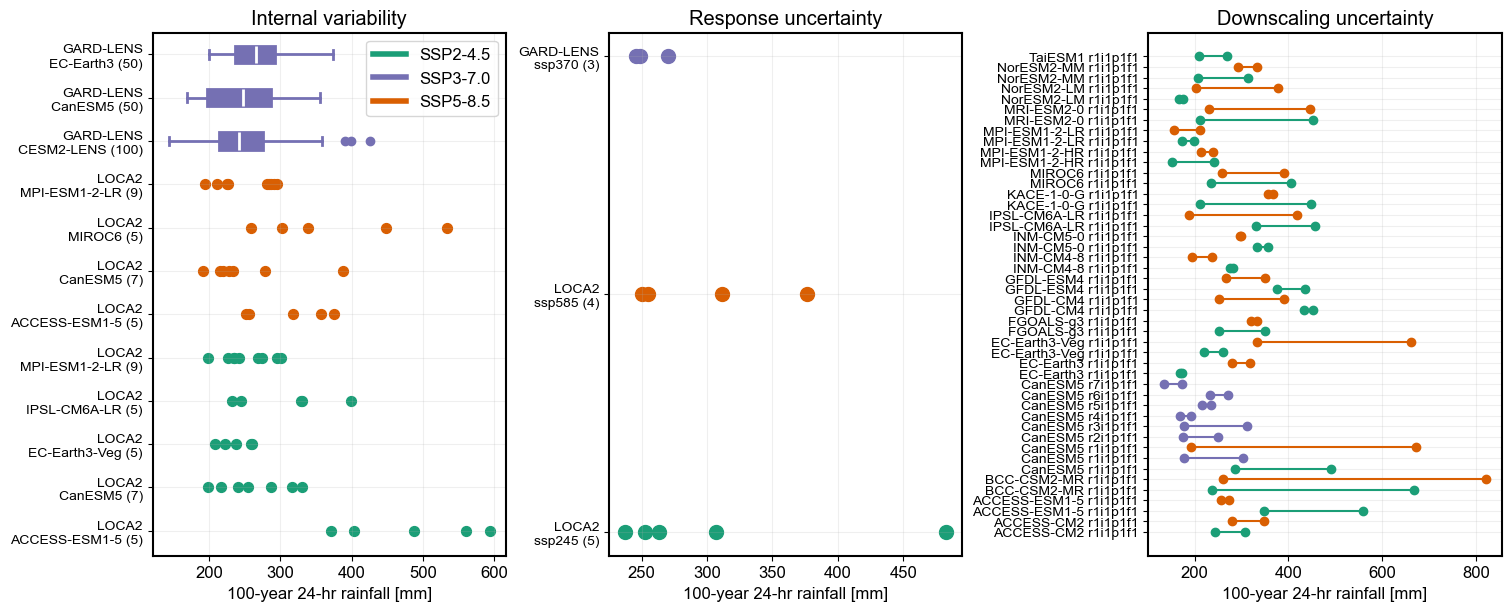

In [29]:
plot_decomp_qual(df_all, limits, plot_col, xlabel)

### Precip: change

In [ ]:
metric_id = "max_pr"
city = "houston"

df_all = fit_gev_all(metric_id, city)

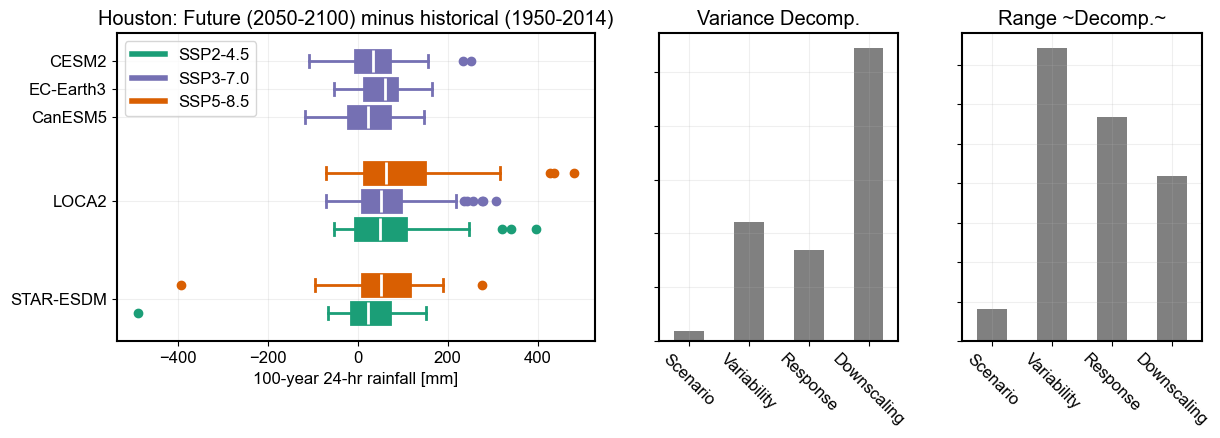

In [ ]:
plot_col = "rl100_diff"
limits = [-np.inf, np.inf]
xlabel = "100-year 24-hr rainfall [mm]"

plot_decomps(df_all, limits, plot_col, xlabel)

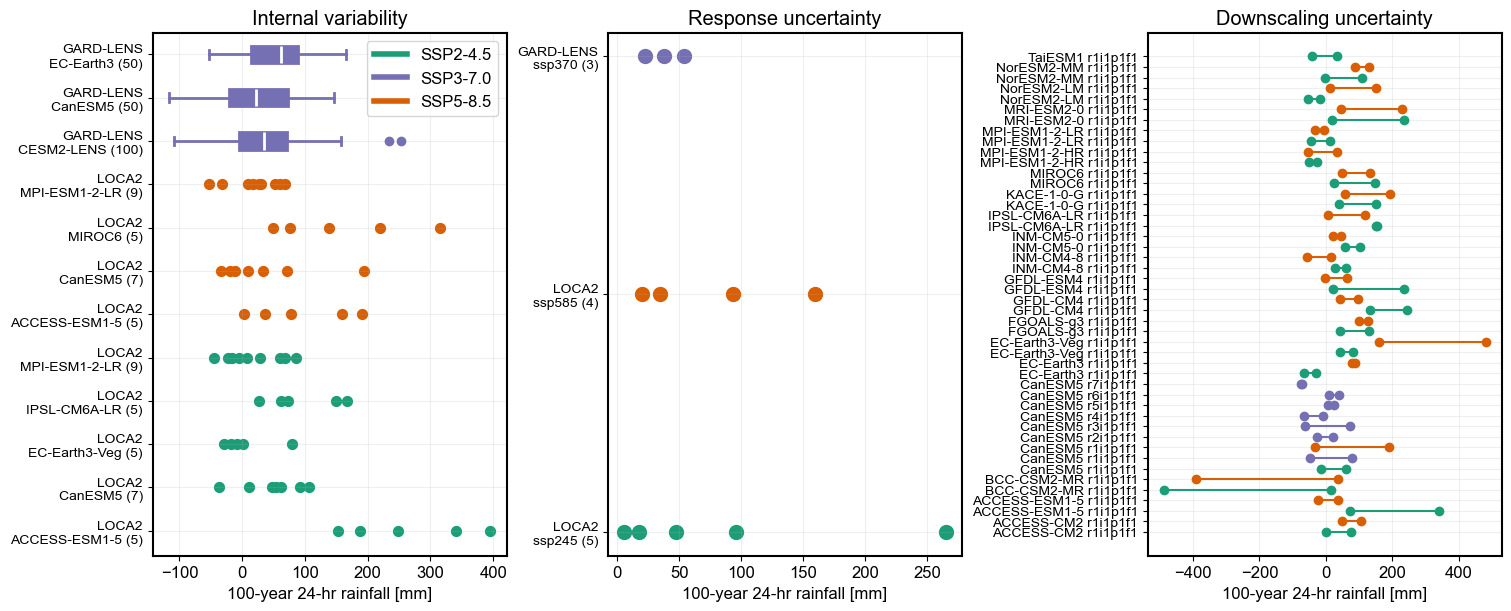

In [34]:
plot_decomp_qual(df_all, limits, plot_col, xlabel)

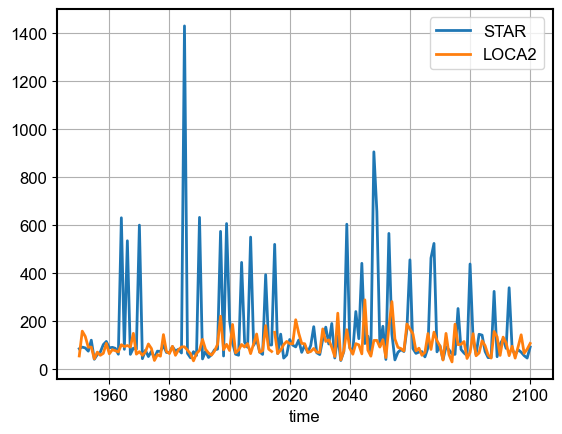

In [ ]:
gcm = "BCC-CSM2-MR"
ssp = "ssp585"

plot_timeseries(city, metric_id, gcm, ssp)

### Tasmin: proj

In [ ]:
metric_id = "min_tasmin"
city = "nyc"

df_all = fit_gev_all(metric_id, city)

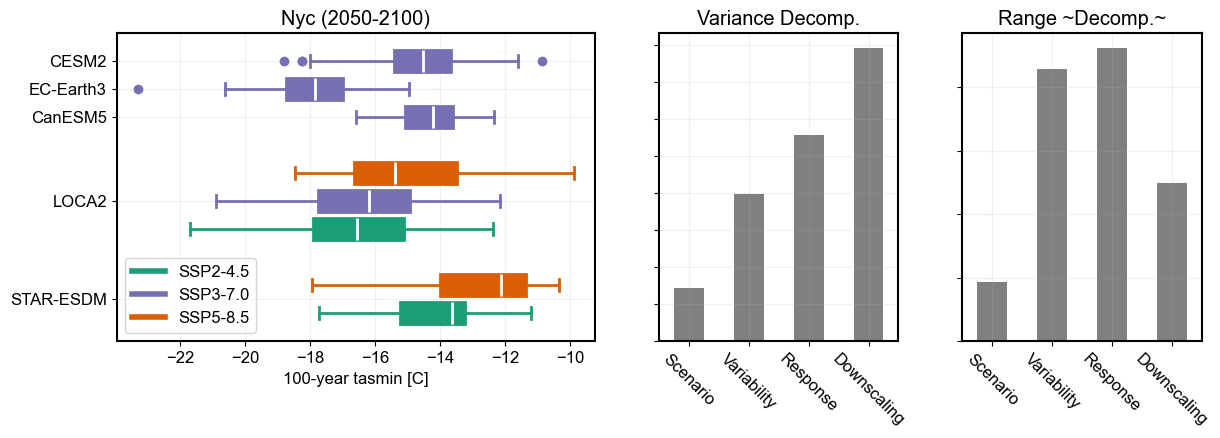

In [ ]:
plot_col = "rl100_proj"
limits = [-np.inf, np.inf]
xlabel = "100-year tasmin [C]"

plot_decomps(df_all, limits, plot_col, xlabel)

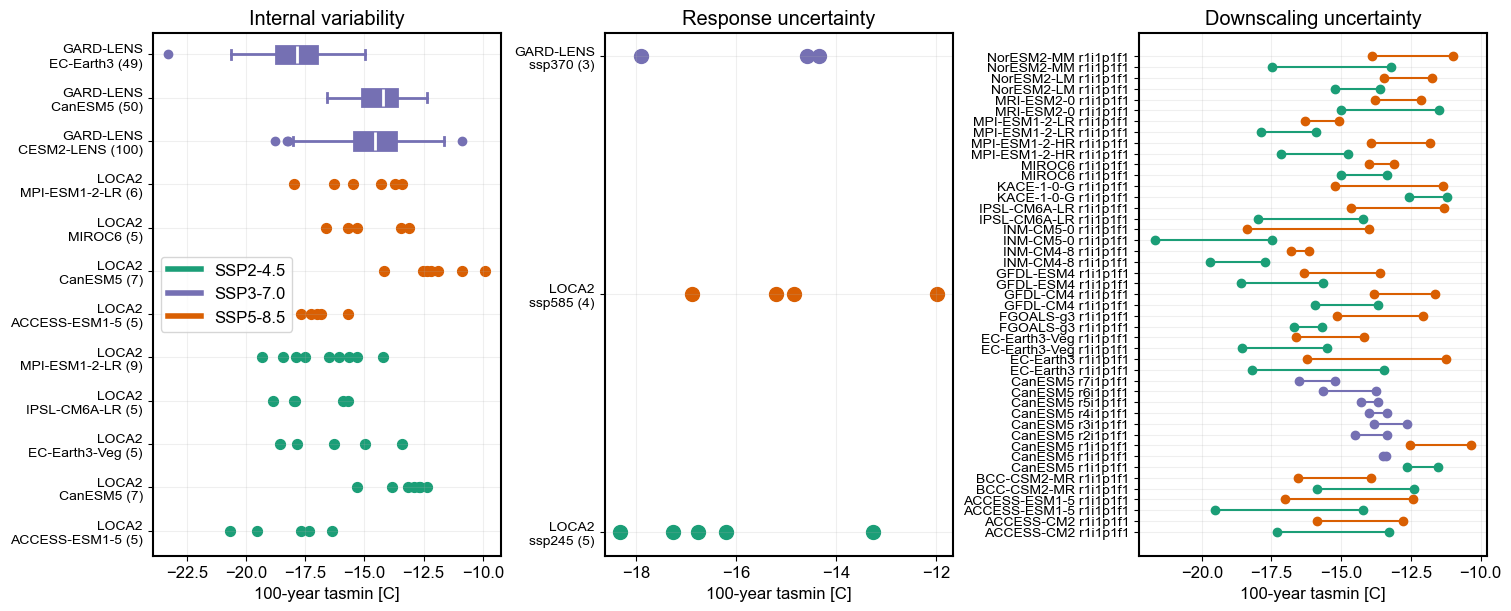

In [27]:
plot_decomp_qual(df_all, limits, plot_col, xlabel)

### Tasmin: change

## Indices for STAR

In [ ]:
# Simple preprocessing function to add model and year coordinates
def _preprocess(ds):
    # Add model and SSP as coordinates
    model = ds.encoding["source"].split("/")[-1].split("_")[2]
    ds = ds.assign_coords(model=model)

    # Time -> year
    ds["time"] = ds["time"].dt.year

    return ds

In [ ]:
# Calculates summary indices for NEX-GDDP-CMIP6 ensemble for given SSP
def get_summary_indices(metric_id, ssp, years, out_path, out_str):
    """
    Current summary indices calculated: mean, 99th quantile, 99% quantile range
    `years` define the window over which all outputs are pooled.
    """

    # Check if done
    if not os.path.isfile(f"{out_path}/{out_str}.nc"):
        # Read all
        ds = xr.open_mfdataset(
            f"{project_data_path}/metrics_regridded/STAR-ESDM/conservative/{metric_id}_*_{ssp}.nc",
            chunks="auto",
            preprocess=_preprocess,
            combine="nested",
            concat_dim=["model"],
        )

        # Time slice
        ds_sel = ds.sel(time=slice(years[0], years[1]))

        ## Summary indices
        # Mean
        ds_mean = ds_sel.mean(dim=["model", "time"]).assign_coords(
            indice="mean"
        )
        # Quantiles
        ds_qlow = ds_sel.chunk(dict(model=-1)).quantile(
            0.005, dim=["model", "time"]
        )
        ds_qhigh = ds_sel.chunk(dict(model=-1)).quantile(
            0.995, dim=["model", "time"]
        )
        ds_qrange = (ds_qhigh - ds_qlow).assign_coords(indice="99range")

        ds_q99 = (
            ds_sel.chunk(dict(model=-1))
            .quantile(0.99, dim=["model", "time"])
            .assign_coords(indice="q99")
        )

        # Store
        ds_out = xr.concat([ds_mean, ds_qrange, ds_q99], dim="indice")
        ds_out.to_netcdf(f"{out_path}/{out_str}.nc")

In [ ]:
%%time
for years in [[2020, 2040], [2050, 2070], [2080, 2100]]:
    for ssp in ["ssp245", "ssp585"]:
        for metric_id in [
            "avg_tas",
            "sum_pr",
            "max_tasmax",
            "max_pr",
            "max_tas",
        ]:
            get_summary_indices(
                metric_id=metric_id,
                ssp=ssp,
                years=years,
                out_path=f"{project_data_path}/summary_indices",
                out_str=f"STAR-ESDM_{ssp}_{str(years[0])}-{str(years[1])}_{metric_id}",
            )

CPU times: user 30.9 s, sys: 3.76 s, total: 34.6 s
Wall time: 2min 43s


## Regrid STAR

In [ ]:
# We use LOCA grid as target
loca_lat_grid = np.linspace(23.90625, 53.46875, 474)
loca_lon_grid = np.linspace(234.53125, 293.46875, 944)

ds_out = xr.Dataset(
    {
        "lat": (
            ["lat"],
            loca_lat_grid,
            {"standard_name": "latitude", "units": "degrees_north"},
        ),
        "lon": (
            ["lon"],
            loca_lon_grid,
            {"standard_name": "longitude", "units": "degrees_east"},
        ),
    }
)

# Add mask from LOCA output
loca_nans = np.load(f"{project_code_path}/code/utils/LOCA2_NaNs.npy")
ds_out["mask"] = xr.DataArray(~loca_nans, dims=["lat", "lon"])

# STAR grid to construct regridder
example_file = glob(f"{project_data_path}/metrics/STAR-ESDM/*.nc")[0]
ds_in = xr.open_dataset(example_file)

# Regridder
conservative_regridder = xe.Regridder(ds_in, ds_out, "conservative")
# nn_s2d_regridder = xe.Regridder(ds_in, ds_out, "nearest_s2d")

In [ ]:
%%time

# Out path
out_path = f"{project_data_path}/metrics_regridded/STAR-ESDM/"

# Regridder
regridder_names = ["conservative"]
regridders = [conservative_regridder]

# Metrics
metrics_ids = ["avg_tas", "sum_pr", "max_tasmax", "max_pr", "max_tas"]

# Loop through all
for regridder_name, regridder in zip(regridder_names, regridders):
    for ssp in ["ssp245", "ssp585"]:
        for gcm in gcms:
            for metric_id in metrics_ids:
                if not os.path.isfile(
                    f"{out_path}/{regridder_name}/{metric_id}_{gcm}_{ssp}.nc"
                ):
                    try:
                        # Read
                        metric, var_id = metric_id.split("_")
                        file_path = glob(
                            f"{project_data_path}/metrics/STAR-ESDM/{metric_id}.downscaled.{gcm}.r1i1p1f1.{var_id}.{ssp}*.nc"
                        )[0]
                        ds_star_in = xr.open_dataset(file_path)
                        ds_star_in = ds_star_in.rename({var_id: metric_id})

                        # NOTE: use high NaN threshold to try to not introduce NaNs
                        # not already present in the LOCA2 grid
                        ds_star_out = regridder(
                            ds_star_in, skipna=True, na_thres=0.99
                        )

                        # Store
                        ds_star_out.to_netcdf(
                            f"{out_path}/{regridder_name}/{metric_id}_{gcm}_{ssp}.nc"
                        )
                        print(f"{metric_id} {gcm} {ssp}")
                    except:
                        print(f"ERROR {metric_id} {gcm} {ssp}")

max_tas ACCESS-CM2 ssp245
max_tas ACCESS-ESM1-5 ssp245
max_tas BCC-CSM2-MR ssp245
max_tas CMCC-ESM2 ssp245
max_tas CanESM5 ssp245
max_tas EC-Earth3 ssp245
max_tas EC-Earth3-Veg ssp245
max_tas EC-Earth3-Veg-LR ssp245
max_tas FGOALS-g3 ssp245
max_tas GFDL-CM4 ssp245
max_tas GFDL-ESM4 ssp245
max_tas INM-CM4-8 ssp245
max_tas INM-CM5-0 ssp245
max_tas IPSL-CM6A-LR ssp245
max_tas KACE-1-0-G ssp245
max_tas KIOST-ESM ssp245
max_tas MIROC6 ssp245
max_tas MPI-ESM1-2-HR ssp245
max_tas MPI-ESM1-2-LR ssp245
max_tas MRI-ESM2-0 ssp245
max_tas NESM3 ssp245
max_tas NorESM2-LM ssp245
max_tas NorESM2-MM ssp245
max_tas TaiESM1 ssp245
max_tas ACCESS-CM2 ssp585
max_tas ACCESS-ESM1-5 ssp585
max_tas BCC-CSM2-MR ssp585
max_tas CMCC-ESM2 ssp585
max_tas CanESM5 ssp585
max_tas EC-Earth3 ssp585
max_tas EC-Earth3-Veg ssp585
max_tas EC-Earth3-Veg-LR ssp585
max_tas FGOALS-g3 ssp585
max_tas GFDL-CM4 ssp585
max_tas GFDL-ESM4 ssp585
max_tas INM-CM4-8 ssp585
max_tas INM-CM5-0 ssp585
max_tas IPSL-CM6A-LR ssp585
max_tas KAC

## Indices for GARD-LENS

In [17]:
# Calculates summary indices for GARD-LENS model ensemble for given SSP
def get_summary_indices(metric_id, model, years, out_path, out_str):
    """
    Current summary indices calculated: mean, 99th quantile, 99% quantile range
    `years` define the window over which all outputs are pooled. 
    """
    
    # Check if done
    if not os.path.isfile(f"{out_path}/{out_str}.nc"):
        # Read all
        ds = xr.open_mfdataset(f"{project_data_path}/metrics_regridded/GARD-LENS/conservative/{metric_id}_{model}_*.nc", chunks='auto')

        # Time slice
        ds = ds.rename({'year':'time'})
        ds_sel = ds.sel(time=slice(years[0],years[1]))
    
        ## Summary indices
        # Mean
        ds_mean = ds_sel.mean(dim=['member', 'time']).assign_coords(indice = 'mean')
        # Quantiles
        ds_qlow = ds_sel.chunk(dict(member=-1)).quantile(0.005, dim=['member', 'time'])
        ds_qhigh = ds_sel.chunk(dict(member=-1)).quantile(0.995, dim=['member', 'time'])
        ds_qrange = (ds_qhigh - ds_qlow).assign_coords(indice = '99range')
    
        ds_q99 = ds_sel.chunk(dict(member=-1)).quantile(0.99, dim=['member', 'time']).assign_coords(indice = 'q99')

        # Store
        ds_out = xr.concat([ds_mean, ds_qrange, ds_q99], dim='indice')
        ds_out.to_netcdf(f"{out_path}/{out_str}.nc")

In [ ]:
%%time
ssp = 'ssp370'

for years in [[2020,2040], [2050,2070], [2080,2100]]:
    for metric_id in ['avg_tas', 'max_pr', 'sum_pr']:
        for model in gard_info.keys():
            get_summary_indices(metric_id = metric_id,
                                model = model,
                                years = years,
                                out_path=f"{project_data_path}/summary_indices",
                                out_str=f"GARD-LENS_{model}_{ssp}_{years[0]}-{years[1]}_{metric_id}")

## Regrid GARD-LENS

In [8]:
# We use LOCA grid as target
loca_lat_grid = np.linspace(23.90625, 53.46875, 474)
loca_lon_grid = np.linspace(234.53125, 293.46875, 944)
    
ds_out = xr.Dataset({"lat": (["lat"], loca_lat_grid,
                             {"standard_name": "latitude", "units": "degrees_north"}),
                     "lon": (["lon"], loca_lon_grid,
                             {"standard_name": "longitude", "units": "degrees_east"})
                    })
    
# Add mask from LOCA output
loca_nans = np.load(f'{project_code_path}/code/utils/LOCA2_NaNs.npy')
ds_out["mask"] = xr.DataArray(~loca_nans, dims=['lat','lon'])
    
# GARD-LENS grid to construct regridder
example_file = f'{gard_path}/GARDLENS_t_mean_stats_CONUS.nc'
ds_in = xr.open_dataset(example_file).isel(year=0, n_ens=0)
    
# Regridder
conservative_regridder = xe.Regridder(ds_in, ds_out, "conservative")
# nn_s2d_regridder = xe.Regridder(ds_in, ds_out, "nearest_s2d")

In [9]:
# Some small preprocessing for GARD-LENS
def _preprocess(ds, gard_stat_id, metric_id):
    # Re-index
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        ds = ds.set_index(n_ens=['gcm', 'scen', 'ens']).unstack('n_ens')
        ds = ds.rename({'gcm':'model', 'scen':'ssp', 'ens':'member'})
    # Rename
    ds = ds.rename({gard_stat_id: metric_id})[[metric_id]]

    return ds

# Regridding function
def regrid_gard(ds_in, gard_var_id, gard_stat_id, model, member, metric_id, regridder, regridder_name, out_path):
    # Check if done
    if not os.path.exists(f"{out_path}/{regridder_name}/{metric_id}_{model}_{member}_ssp370.nc"):
        # Select GCM and member
        ds_in = ds_in.where((ds_in.gcm == model) & (ds_in.ens == member), drop=True)
    
        # Tidy
        ds_in = _preprocess(ds_in, gard_stat_id, metric_id)
    
        # Regrid
        # NOTE: use high NaN threshold to try to not introduce NaNs
        # not already present in the LOCA2 grid
        ds_out = regridder(ds_in, skipna=True, na_thres=0.99)
        
        # Store
        # comp = dict(zlib=True, complevel=5)
        # encoding = {var: comp for var in ds_out.data_vars}
        ds_out.to_netcdf(f"{out_path}/{regridder_name}/{metric_id}_{model}_{member}_ssp370.nc")

In [10]:
# Run it
out_path = f"{project_data_path}/metrics_regridded/GARD-LENS/"

#####################
# avg tas
gard_var_id = 't_mean'
gard_stat_id = 'mean'
metric_id = 'avg_tas'

ds_in = xr.open_dataset(f'{gard_path}/GARDLENS_{gard_var_id}_stats_CONUS.nc')

for model in gard_info.keys():
    for member in gard_info[model]:
        regrid_gard(ds_in = ds_in,
                    gard_var_id = gard_var_id, 
                    gard_stat_id = gard_stat_id,
                    model = model,
                    member = member,
                    metric_id = metric_id,
                    regridder = conservative_regridder,
                    regridder_name = 'conservative',
                    out_path = out_path)

#####################
# max precip
gard_var_id = 'pcp'
gard_stat_id = 'max'
metric_id = 'max_pr'

ds_in = xr.open_dataset(f'{gard_path}/GARDLENS_{gard_var_id}_stats_CONUS.nc')

for model in gard_info.keys():
    for member in gard_info[model]:
        regrid_gard(ds_in = ds_in,
                    gard_var_id = gard_var_id, 
                    gard_stat_id = gard_stat_id,
                    model = model,
                    member = member,
                    metric_id = metric_id,
                    regridder = conservative_regridder,
                    regridder_name = 'conservative',
                    out_path = out_path)

#####################
# sum precip
gard_var_id = 'pcp'
gard_stat_id = 'sum'
metric_id = 'sum_pr'

ds_in = xr.open_dataset(f'{gard_path}/GARDLENS_{gard_var_id}_stats_CONUS.nc')

for model in gard_info.keys():
    for member in gard_info[model]:
        regrid_gard(ds_in = ds_in,
                    gard_var_id = gard_var_id, 
                    gard_stat_id = gard_stat_id,
                    model = model,
                    member = member,
                    metric_id = metric_id,
                    regridder = conservative_regridder,
                    regridder_name = 'conservative',
                    out_path = out_path)

## Indices for LOCA2

In [5]:
# Simple preprocessing function to add model and year coordinates
def _preprocess(ds):
    # Add model coordinate
    model = ds.encoding['source'].split('/')[-1].split('.')[1]
    ds = ds.assign_coords(model = model)

    # Add member
    member = ds.encoding['source'].split('/')[-1].split('.')[3]
    ds = ds.assign_coords(member = member)

    # Time -> year
    ds['time'] = ds['time'].dt.year

    return ds

In [11]:
# Calculates summary indices for CIL-GDPCIR ensemble for given SSP
def get_summary_indices(metric_id, ssp, years, out_path, out_str):
    """
    Current summary indices calculated: mean, 99th quantile, 99% quantile range
    `years` define the window over which all outputs are pooled. 
    """
    # Check if done
    if not os.path.isfile(f"{out_path}/{out_str}.nc"):
        # Read
        ds_models = []
        for model in models:
            files = glob(f"{project_data_path}/metrics/LOCA2/{metric_id}.{model}.{ssp}.r*.nc")
            # Check files exist
            if len(files) > 0:
                ds_members = []
                # Read all members
                for member in loca_all[model].keys():
                    if len(glob(f"{project_data_path}/metrics/LOCA2/{metric_id}.{model}.{ssp}.{member}.*.nc")) > 0:
                        try:
                            ds_tmp = xr.open_mfdataset(f"{project_data_path}/metrics/LOCA2/{metric_id}.{model}.{ssp}.{member}.*.nc",
                                                       preprocess=_preprocess)
                            ds_members.append(ds_tmp)
                        except Exception as e:
                            except_path = f"{project_code_path}/code/logs"
                            with open(f"{except_path}/{model}_{member}_{ssp}_{metric_id}_LOCA.txt", "w") as f:
                                f.write(str(e))
            # Combine & append members
            ds_models.append(xr.concat(ds_members, dim="member", fill_value=np.nan))
        # Combine models
        ds = xr.concat(ds_models, dim="model", fill_value=np.nan)

        # Rename
        ds = ds.rename({list(ds.data_vars)[0]: metric_id})

        # Time slice
        ds_sel = ds.sel(time=slice(years[0],years[1]))#.chunk(dict(model=-1, time=-1, member=-1, lat=50, lon=100))
    
        ## Summary indices
        # Mean
        ds_mean = ds_sel.mean(dim=['model', 'time', 'member']).assign_coords(indice = 'mean')
        # Quantiles
        ds_qlow = ds_sel.quantile(0.005, dim=['model', 'time', 'member'])
        ds_qhigh = ds_sel.quantile(0.995, dim=['model', 'time', 'member'])
        ds_qrange = (ds_qhigh - ds_qlow).assign_coords(indice = '99range')
    
        ds_q99 = ds_sel.quantile(0.99, dim=['model', 'time', 'member']).assign_coords(indice = 'q99')

        # Store
        ds_out = xr.concat([ds_mean, ds_qrange, ds_q99], dim='indice')
        ds_out.to_netcdf(f"{out_path}/{out_str}.nc")

In [ ]:
%%time
for years in [[2020,2040], [2050,2070], [2080,2100]]:
    for ssp in ['ssp245', 'ssp370', 'ssp585']:
        for metric_id in ['avg_tas', 'sum_pr', 'max_tasmax', 'max_pr', 'max_tas']:
            get_summary_indices(metric_id = metric_id,
                                ssp = ssp,
                                years = years,
                                out_path=f"{project_data_path}/summary_indices",
                                out_str=f"LOCA2_{ssp}_{str(years[0])}-{str(years[1])}_{metric_id}")